# House Prices - Advanced Regression techniques
[House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

## Description
- Price prediction techniques
- Much more influences price negotiations than the number of bedrooms and bathrooms
- 79 explanatory variables describing almost every aspect of residential homes in Ames, Iowa
- Predict the final price of each home

Ames Housing dataset was compiled by Dean De Cock for use in data science education. Its and interesting alternative for the Boston Housing dataset

## Evaluation

### Goal
- Predict the sales price for each house
- For each Id in the test set, you must predict SalePrice variable

### Metric
- Submissions are evaluated on Root Mean Squared Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price
- Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

### Submission File Format
- Two columns CSV: `Id,SalePrice`

# Importing libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!wc -l inputs/train.csv

1461 inputs/train.csv


In [3]:
!wc -l inputs/test.csv

1460 inputs/test.csv


As we can see, both train and test CSVs are very small in # of instances ~1.5k, which can be a little bit challenging to test and train.
Prediction using any neural networks models appear to be difficult given there are few examples to train

Let's observe overall dataset shape

In [4]:
train_df = pd.read_csv("./inputs/train.csv")
test_df = pd.read_csv("./inputs/test.csv")

print("Dataset shapes, train and test: ",train_df.shape, test_df.shape)

Dataset shapes, train and test:  (1460, 81) (1459, 80)


Appears to have ~79 features, 1 Id column and 1 column with the target value in train dataset.
Let's obtain the target variable name

In [5]:
set(train_df.columns) - set(test_df.columns)

{'SalePrice'}

# Exploratory Data Analysis

Let's investigate dataset features, understand their relation with the predicted variable `SalePrice` and draw conclusions regarding feature engineering / dataset preparation for models.

It's also interesting to identify whether or not this is a linear problem or not. I suppose it isn't, given that there must be non-ordinal categorical variables in a housing dataset

## General configuration of the dataset
- There are ~33 integer predictors, some of them seem to be ordinal categoric variables (e.g., LotArea)
- There are only ~3 float variables, which would suggest continuous variables
- There are lots of categorical variables with type string, which suggest non-linearity between predictors and predicted variables

Let's further investigate each data type by null values, ranges, outliers and relation to the target SalePrice variable

In [6]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
train_df.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [8]:
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [9]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Float predictors
- The `GarageYrBlt` and `LotFrontage` variables seem relatively linearly correlated with `SalePrice`, which shows they can be good predictors
- Taking the log of both `SalePrice` and `LotFrontage` seem to reduce the skewness of data and effect of outliers, laeding to a closer to linear relationship
- `LotFrontage` has lots of null values and its log follow ~normal distribution, which means filling with mean/median values is not a bad idea
- `GarageYrBlt` is skewed to the right and does not seem possible to unskew, filling nulls with zero as it represents houses without garage
- `MasVnrArea` has a concentration of values on 0 (no thermal insultation), and a few null values, wich also seem to represent no insulation (fill with zero)

### Visualizing data

In [10]:
float_features = train_df.select_dtypes(include='float64').columns.tolist()

<Axes: xlabel='SalePrice', ylabel='Count'>

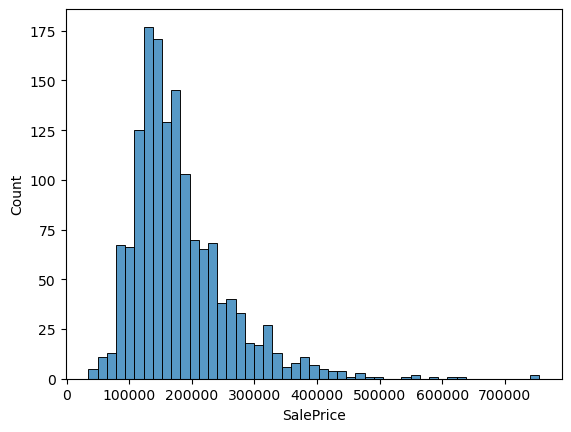

In [11]:
float_train_df = train_df[["SalePrice"]+ float_features]
sns.histplot(train_df["SalePrice"])

<Axes: xlabel='SalePrice', ylabel='Count'>

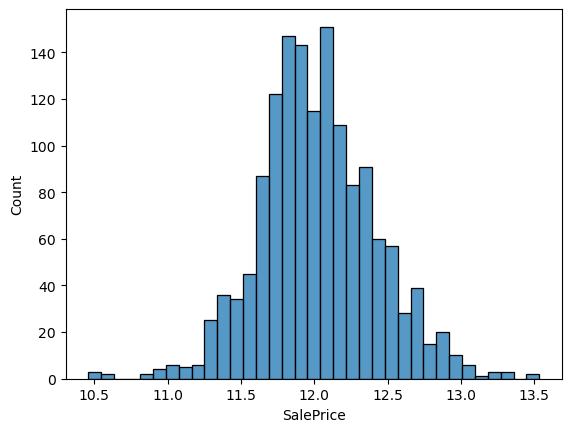

In [12]:
sns.histplot(np.log(float_train_df["SalePrice"]))

<Axes: xlabel='LotFrontage', ylabel='SalePrice'>

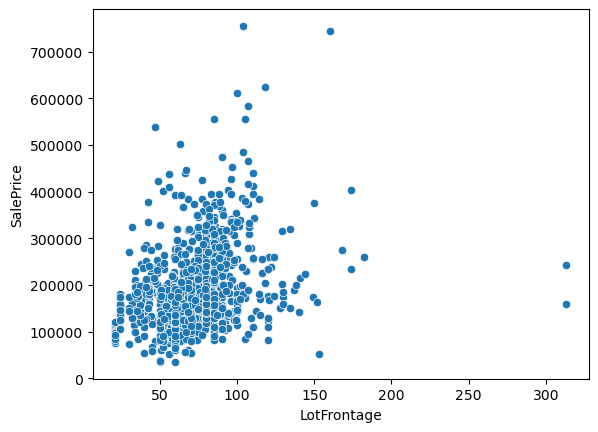

In [13]:
sns.scatterplot(float_train_df, x=float_features[0], y='SalePrice')

<Axes: xlabel='LotFrontage', ylabel='SalePrice'>

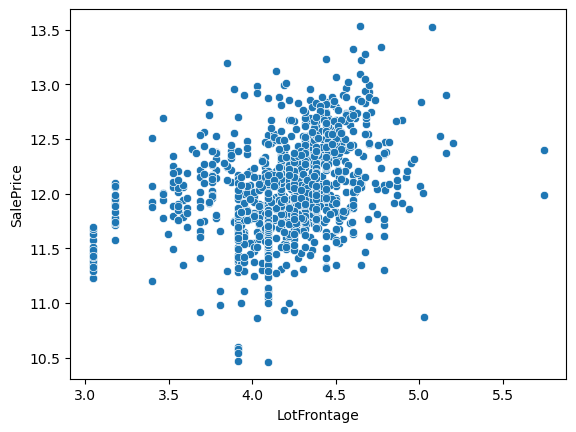

In [14]:
sns.scatterplot(x=np.log(float_train_df[float_features[0]]), y=np.log(float_train_df["SalePrice"]))

<Axes: xlabel='MasVnrArea', ylabel='SalePrice'>

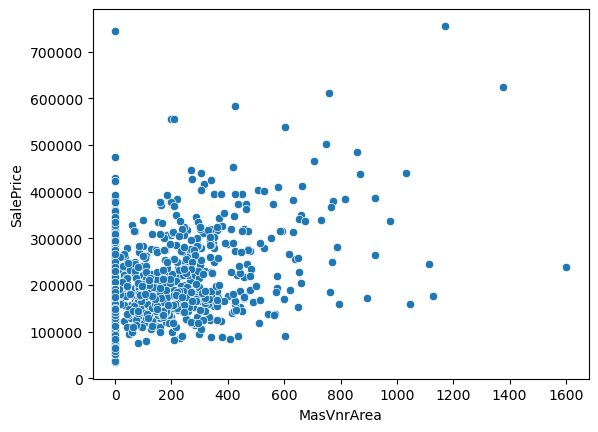

In [15]:
sns.scatterplot(float_train_df, x=float_features[1], y='SalePrice')

<Axes: xlabel='MasVnrArea', ylabel='SalePrice'>

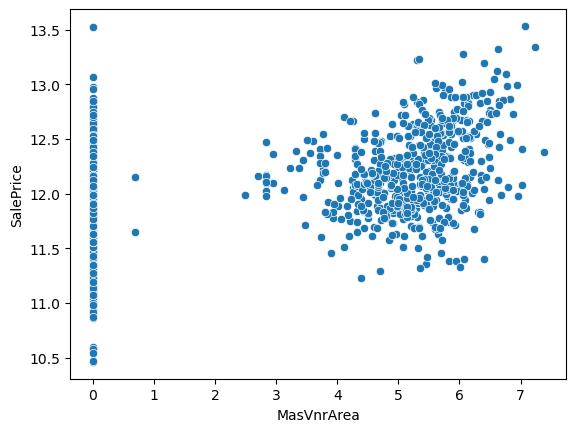

In [16]:
sns.scatterplot(x=np.log(float_train_df[float_features[1]] + 1), y=np.log(float_train_df["SalePrice"]))

<Axes: xlabel='GarageYrBlt', ylabel='SalePrice'>

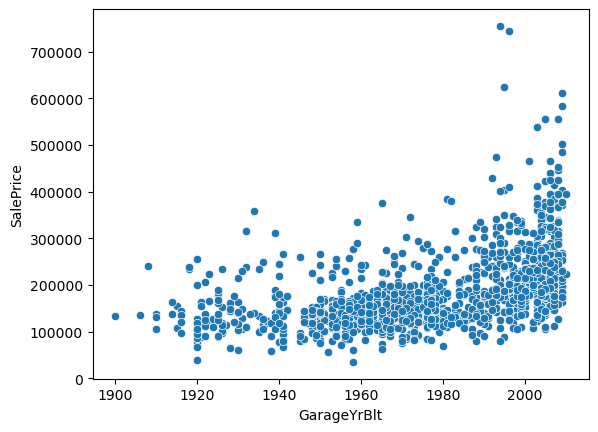

In [17]:
sns.scatterplot(float_train_df, x=float_features[2], y='SalePrice')

<Axes: xlabel='GarageYrBlt', ylabel='SalePrice'>

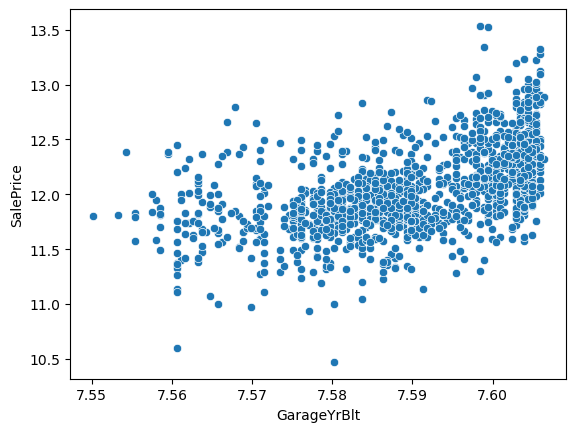

In [18]:
sns.scatterplot(x=np.log(float_train_df[float_features[2]] + 1), y=np.log(float_train_df["SalePrice"]))

array([[<Axes: title={'center': 'SalePrice'}>,
        <Axes: title={'center': 'LotFrontage'}>],
       [<Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'GarageYrBlt'}>]], dtype=object)

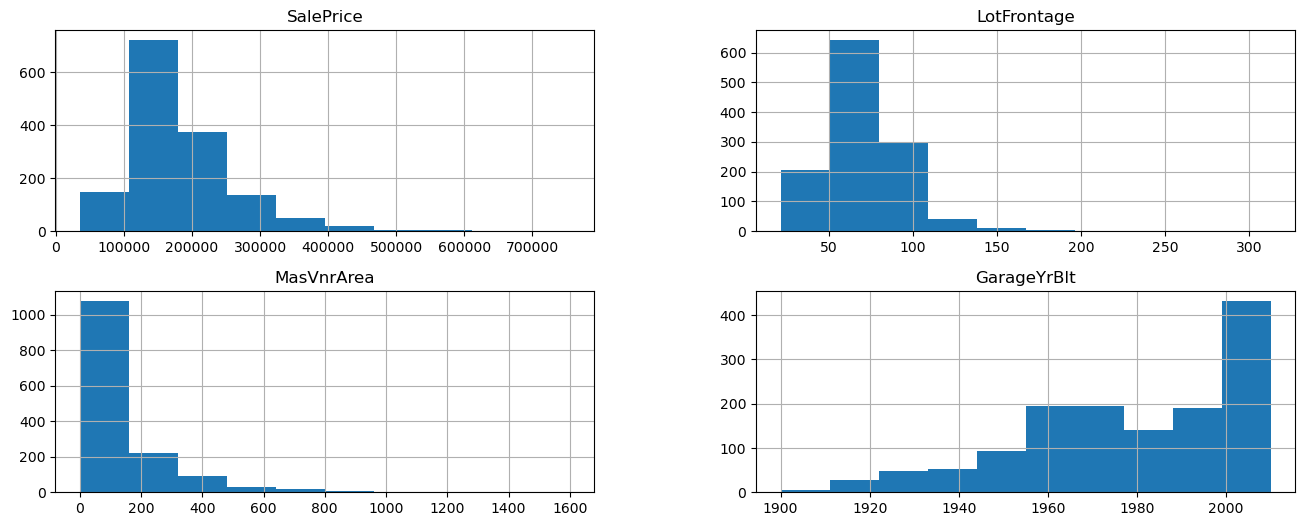

In [20]:
float_train_df.hist(figsize = (16,6))

array([[<Axes: title={'center': 'SalePrice'}>,
        <Axes: title={'center': 'LotFrontage'}>],
       [<Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'GarageYrBlt'}>]], dtype=object)

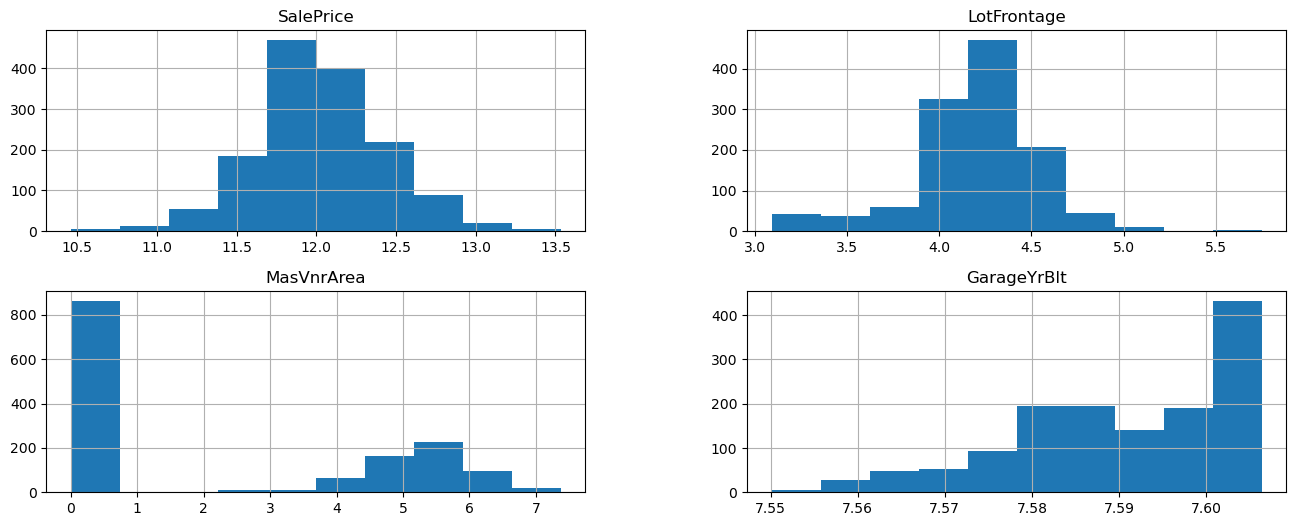

In [21]:
np.log(float_train_df+1).hist(figsize = (16,6))

### Nulls
- No null values on `SalePrice`
- `LotFrontage`, `GarageYrBlt` and `MasVnrArea` have null values
- `MasVnrArea` has a lot of concentrated values on zero, which means

In [27]:
float_train_df.isnull().sum()

SalePrice        0
LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

In [28]:
float_train_df.describe()

,SalePrice,LotFrontage,MasVnrArea,GarageYrBlt
count,1460.000000,1201.000000,1452.000000,1379.000000
mean,180921.195890,70.049958,103.685262,1978.506164
std,79442.502883,24.284752,181.066207,24.689725
min,34900.000000,21.000000,0.000000,1900.000000
25%,129975.000000,59.000000,0.000000,1961.000000
50%,163000.000000,69.000000,0.000000,1980.000000
75%,214000.000000,80.000000,166.000000,2002.000000
max,755000.000000,313.000000,1600.000000,2010.000000


In [36]:
train_df.loc[train_df["GarageYrBlt"].isnull(),train_df.columns.str.startswith("Garage")]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
39,NaN,NaN,NaN,0,0,NaN,NaN
48,NaN,NaN,NaN,0,0,NaN,NaN
78,NaN,NaN,NaN,0,0,NaN,NaN
88,NaN,NaN,NaN,0,0,NaN,NaN
89,NaN,NaN,NaN,0,0,NaN,NaN
...,...,...,...,...,...,...,...
1349,NaN,NaN,NaN,0,0,NaN,NaN
1407,NaN,NaN,NaN,0,0,NaN,NaN
1449,NaN,NaN,NaN,0,0,NaN,NaN
1450,NaN,NaN,NaN,0,0,NaN,NaN


In [41]:
train_df.loc[(train_df["MasVnrArea"] == 0) | (train_df["MasVnrArea"].isnull()),train_df.columns.str.startswith("MasVnr")]

,MasVnrType,MasVnrArea
1,None,0.0
3,None,0.0
5,None,0.0
8,None,0.0
9,None,0.0
...,...,...
1454,None,0.0
1455,None,0.0
1457,None,0.0
1458,None,0.0


### Test data

In [29]:
floating_test_df = test_df[float_features]

array([[<Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'MasVnrArea'}>],
       [<Axes: title={'center': 'GarageYrBlt'}>, <Axes: >]], dtype=object)

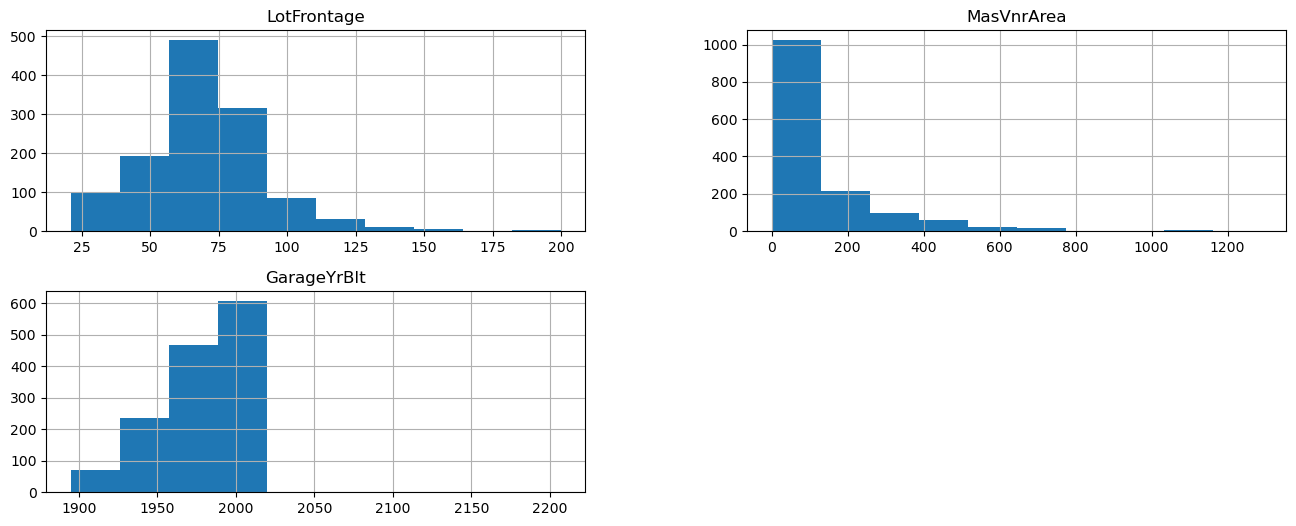

In [30]:
floating_test_df.hist(figsize=(16,6))

array([[<Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'MasVnrArea'}>],
       [<Axes: title={'center': 'GarageYrBlt'}>, <Axes: >]], dtype=object)

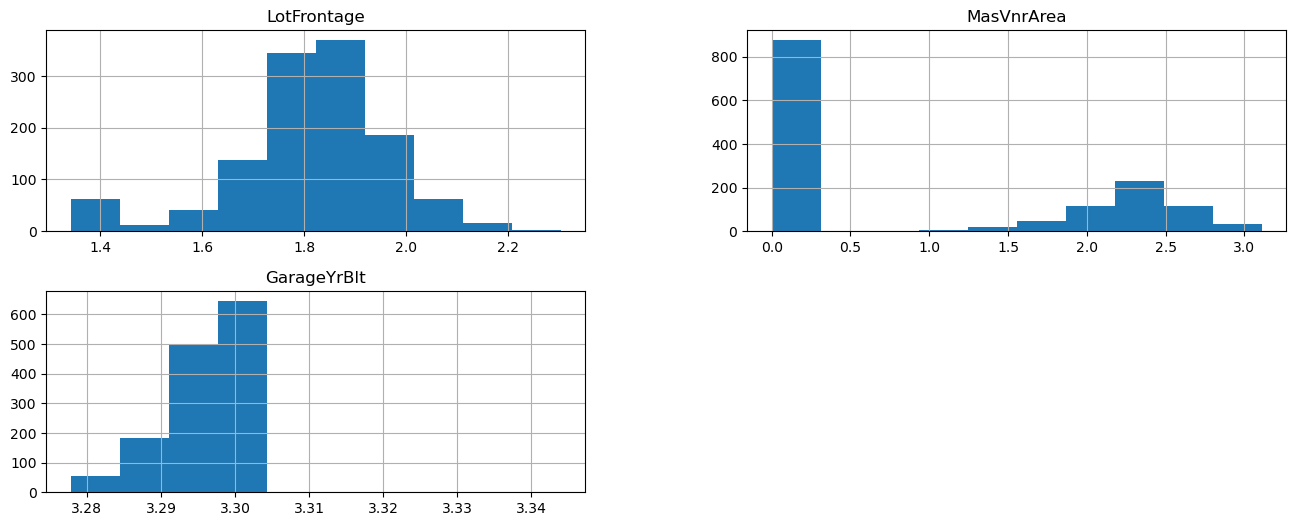

In [31]:
np.log10(floating_test_df+1).hist(figsize=(16,6))

In [33]:
floating_test_df.isnull().sum()

LotFrontage    227
MasVnrArea      15
GarageYrBlt     78
dtype: int64

## Int predictors
- No nulls to fill
- Many variables seem not to be super correlated with `SalePrice`
- Many features appear to not follow a direct linear relationship, which favors the usage of non-linear methods
- May require treating outlier values

### Nulls
- No direct null values on int variables

In [53]:
int_features = train_df.drop(["Id","SalePrice"], axis=1).select_dtypes(include="int64").columns.tolist()

In [94]:
train_df[int_features].isnull().sum()

MSSubClass       0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
dtype: int64

In [95]:
train_df[int_features].describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0
BsmtUnfSF,1460.0,567.240411,441.866955,0.0,223.00,477.5,808.00,2336.0
TotalBsmtSF,1460.0,1057.429452,438.705324,0.0,795.75,991.5,1298.25,6110.0


### Visualizing data
- Many variables follow the `GarageYrBlt` condition where there are lots of `SalePrice` values mapped on a zero value, while other

array([[<Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>],
       [<Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>],
       [<Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>],
       [<Axes: title={'center': 'BedroomAbvGr'}>,
        <Axes: title={'center': 'KitchenAbvGr'}>,
        <Axes: title={'center': 'Tot

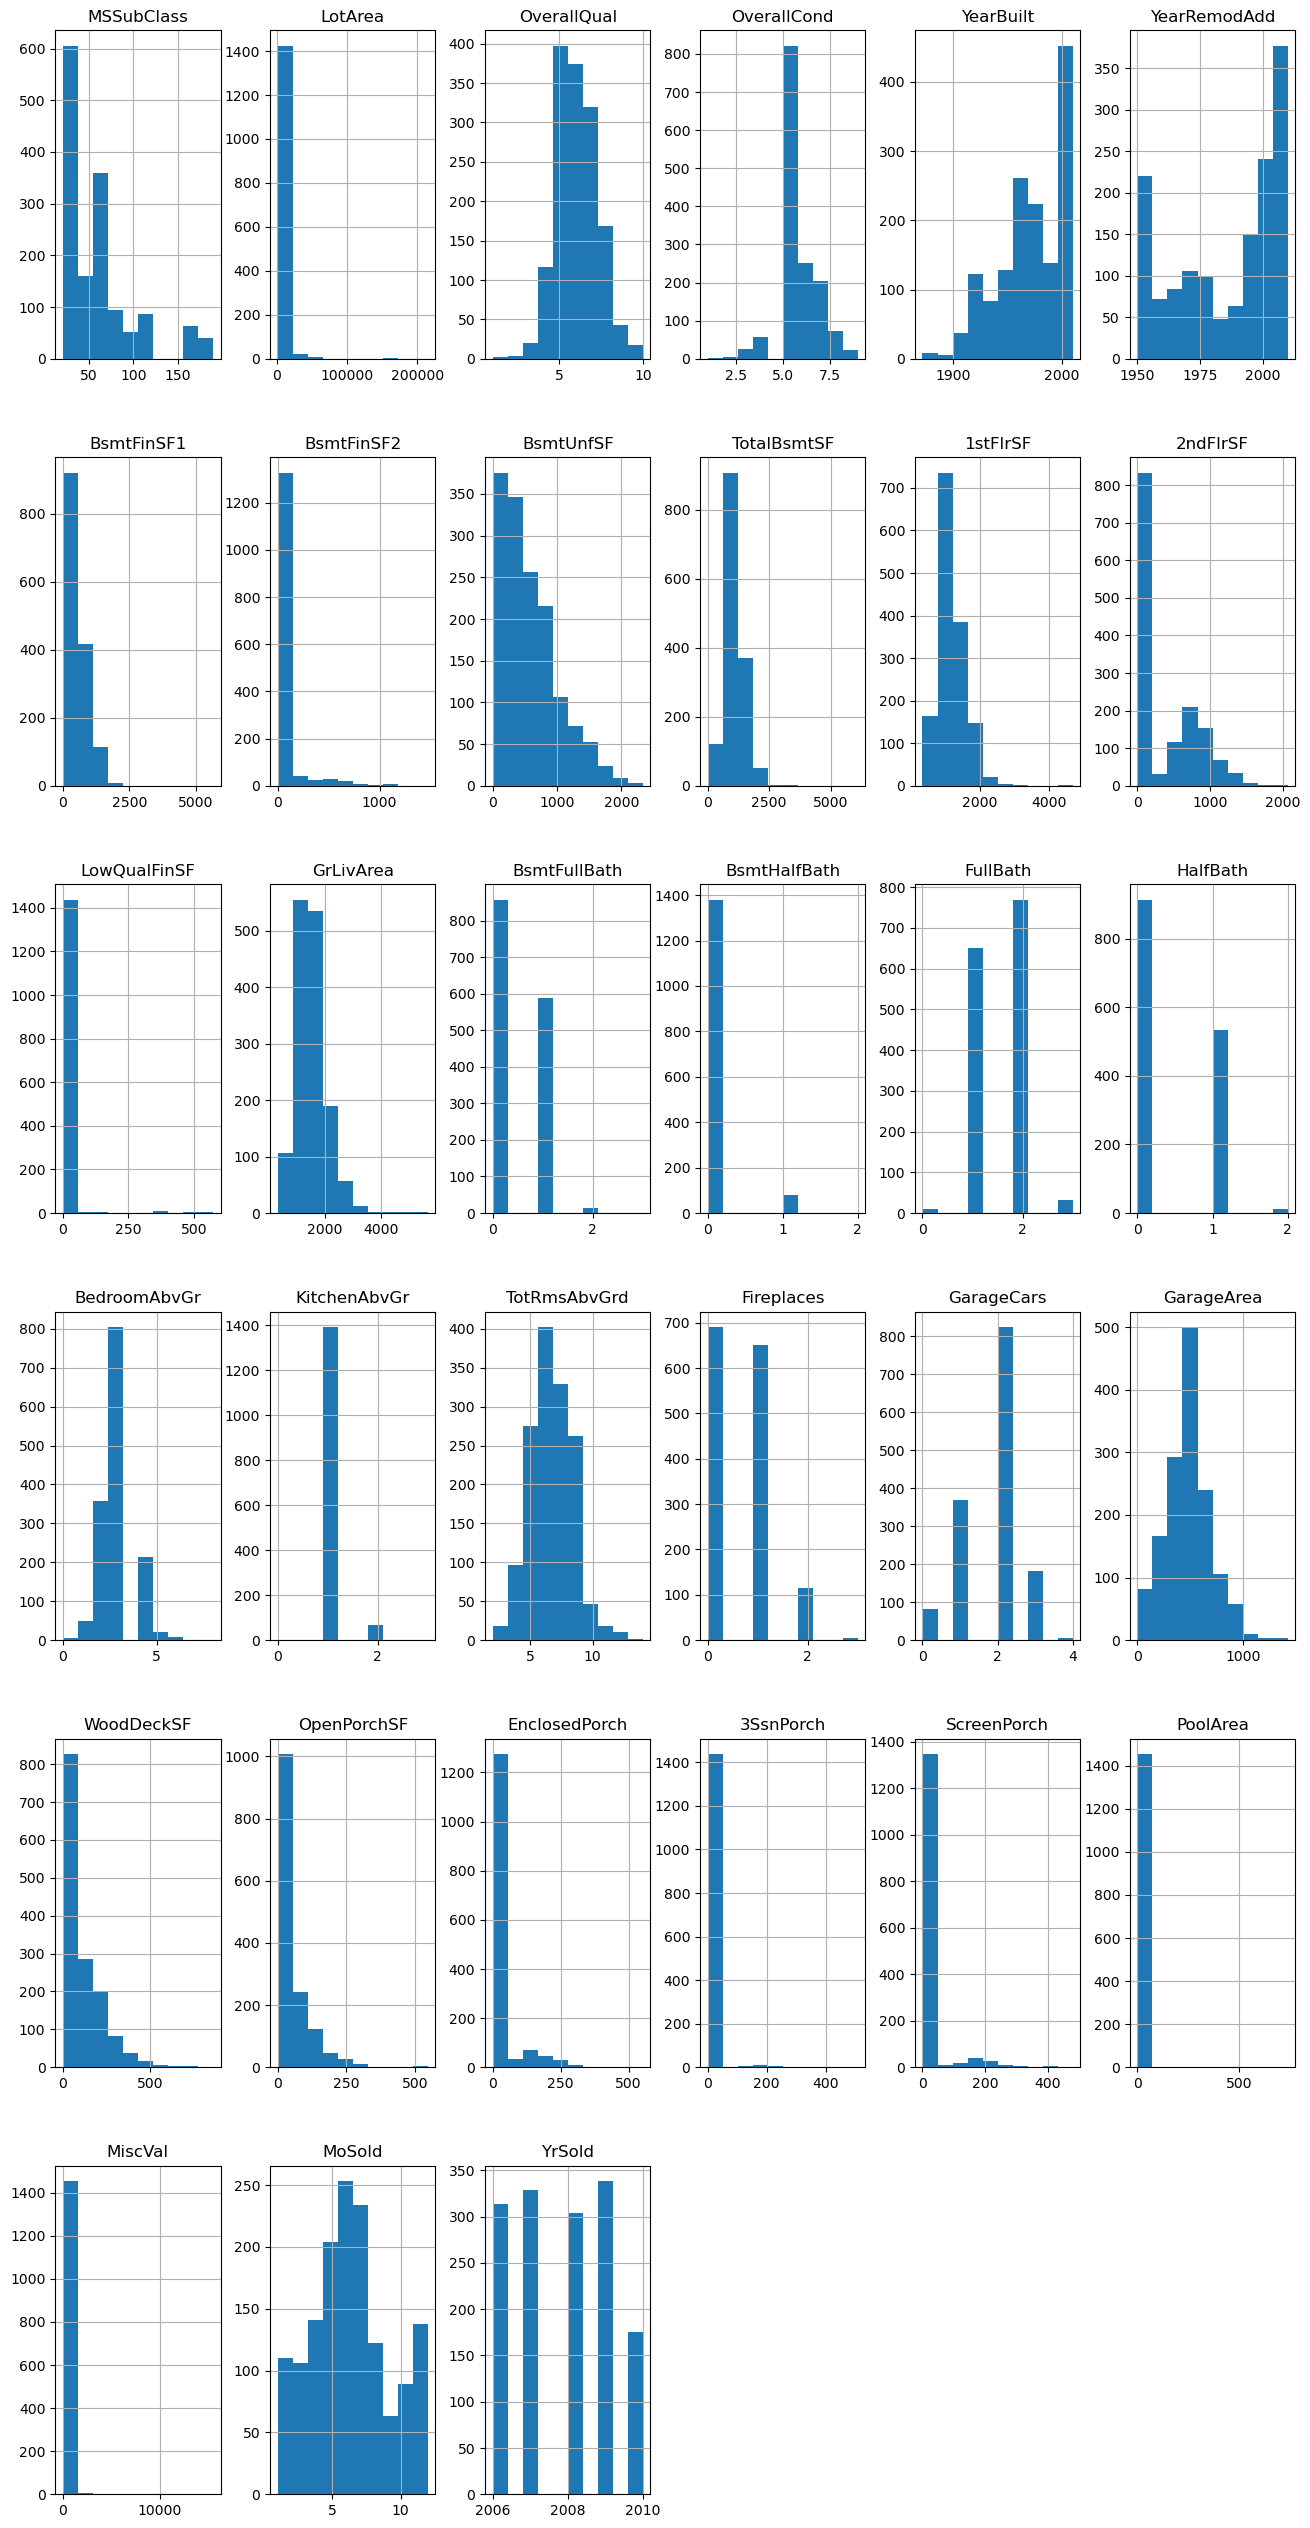

In [96]:
train_df[int_features].hist(figsize=(16,32))

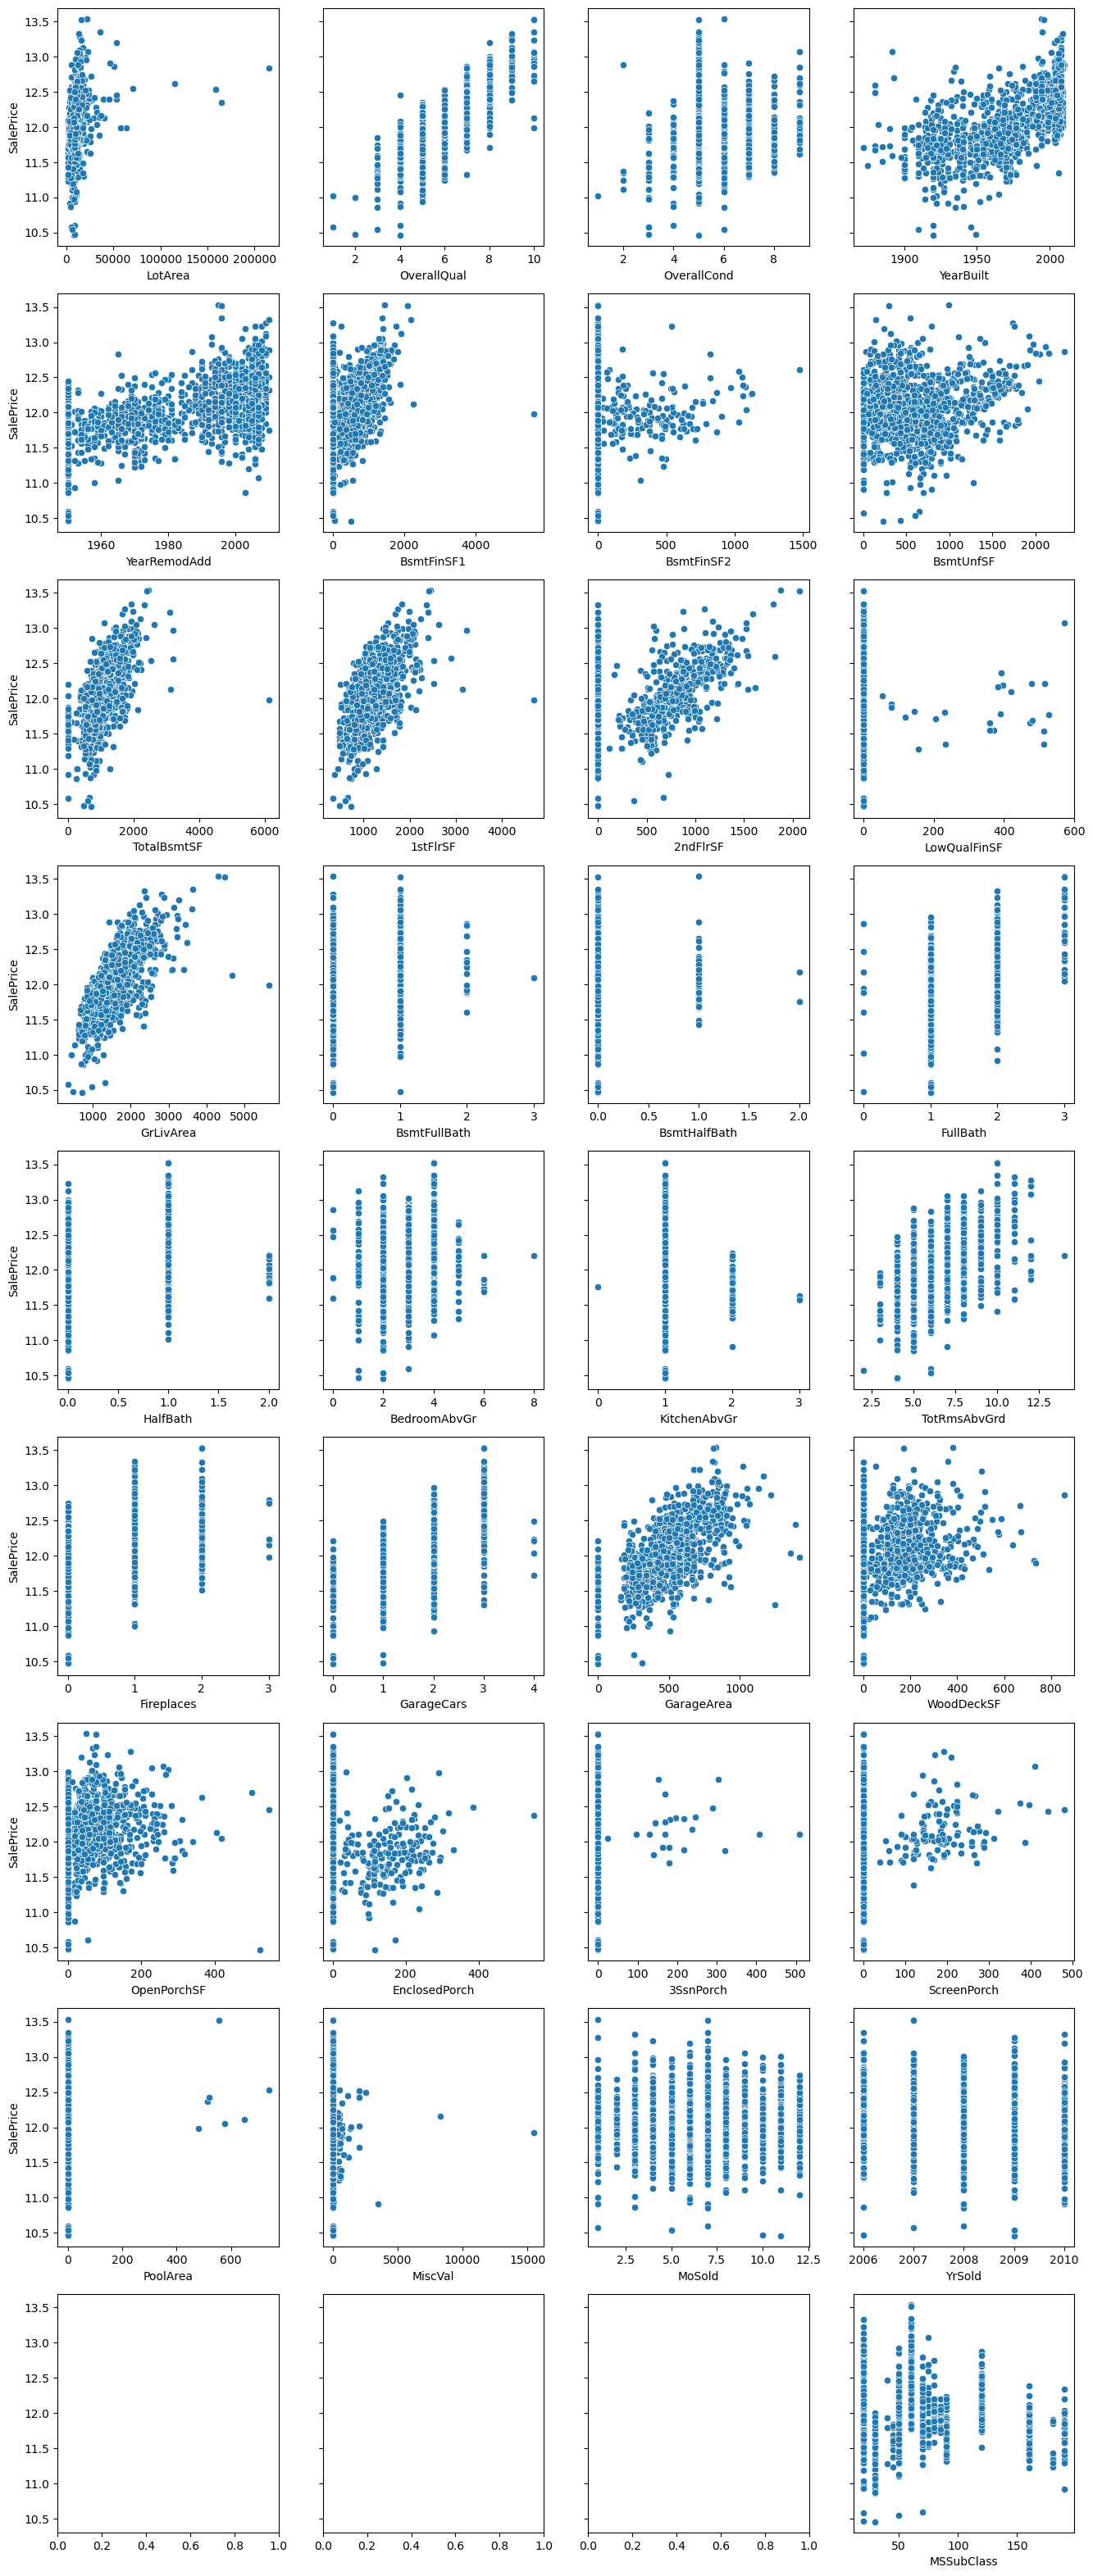

In [109]:
number_of_columns = 4
number_of_rows = len(int_features) // number_of_columns + (len(int_features) % number_of_columns > 0)
fig, axes = plt.subplots(nrows = number_of_rows, ncols= number_of_columns, sharey=True,
                        figsize=(16,40))

for i,col in enumerate(int_features):
    row_idx = i // number_of_columns  + (i % number_of_columns > 0) -1
    col_idx = i % number_of_columns - 1
    sns.scatterplot(train_df, x=col, y=np.log(train_df["SalePrice"]), ax=axes[row_idx, col_idx])
    # axes[row_idx, col_idx].title.set_text(col)

## Categorical predictors
**Nulls**
- Almos all values from the following values are null, therefore discard variables: `["PoolQC","Alley","Fence","MiscFeature","FireplaceQu"]`
- It seems that there are no nulls named as NA, null, "" or "-"
- Variables that start with "Garage", "Bsmt" and "MasVnrType" have meaningfull nan values, substitute by "NAN"
- Fill 'Electrical' with most common vlaue (mode)


**Transforming**
- Transform the following variables using an ordinal encoder (good to bad)

`['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
'Functional', 'GarageType', 'GarageFinish', 'GarageQual',
'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']`

In [111]:
categorical_features = train_df.select_dtypes(include="object").columns.tolist()

In [128]:
print(categorical_features)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [132]:
train_df.shape

(1460, 81)

### Nulls
- Almos all values from the following values are null, therefore discard variables: `["PoolQC","Alley","Fence","MiscFeature","FireplaceQu"]
- It seems that there are no nulls named as NA, null, "" or "-"
- Variables that start with "Garage", "Bsmt" and "MasVnrType" have meaningfull nan values, substitute by "NAN"
- Fill 'Electrical' with most common vlaue (mode)

In [131]:
train_df[categorical_features].isnull().sum().sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
GarageType         81
GarageCond         81
GarageQual         81
GarageFinish       81
BsmtFinType2       38
BsmtExposure       38
BsmtFinType1       37
BsmtQual           37
BsmtCond           37
MasVnrType          8
Electrical          1
Functional          0
KitchenQual         0
CentralAir          0
HeatingQC           0
Heating             0
PavedDrive          0
SaleType            0
MSZoning            0
Street              0
Condition2          0
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
BldgType            0
Foundation          0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
ExterQual           0
ExterCond           0
SaleCondition       0
dtype: int64

In [139]:
electrical_mode = train_df["Electrical"].value_counts().idxmax()
print(electrical_mode)

SBrkr


In [134]:
((train_df[categorical_features] == "NA") | (train_df[categorical_features] == "") | (train_df[categorical_features] == "-")).sum()

MSZoning         0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
FireplaceQu      0
GarageType       0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
PoolQC           0
Fence            0
MiscFeature      0
SaleType         0
SaleCondition    0
dtype: int64

### Visualizing data, label encoding

In [174]:
categ_train_df = train_df[categorical_features]
fillna_with_nan_mask = [x.startswith("Garage") or x.startswith("Bsmt") or x.startswith("MasVnrType") for x in categorical_features]

categ_train_df.loc[:,fillna_with_nan_mask] = categ_train_df[categ_train_df.columns[fillna_with_nan_mask]].fillna("NAN")
categ_train_df.loc[:,"Electrical"] = categ_train_df[categ_train_df.columns[fillna_with_nan_mask]].fillna("NAN")

categ_train_df.isnull().sum().sort_values(ascending=False)

C:\Users\gransotto gustavo\AppData\Local\Temp\ipykernel_19676\3212575968.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categ_train_df.loc[:,fillna_with_nan_mask] = categ_train_df[categ_train_df.columns[fillna_with_nan_mask]].fillna("NAN")
C:\Users\gransotto gustavo\AppData\Local\Temp\ipykernel_19676\3212575968.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categ_train_df.loc[:,"Electrical"] = categ_train_df[categ_train_df.columns[fillna_with_nan_mask]].fillna("NAN")


PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
MSZoning            0
KitchenQual         0
BsmtFinType1        0
BsmtFinType2        0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
GarageType          0
Functional          0
BsmtCond            0
GarageFinish        0
GarageQual          0
GarageCond          0
PavedDrive          0
SaleType            0
BsmtExposure        0
BsmtQual            0
Street              0
Foundation          0
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          0
ExterQual           0
ExterCond           0
SaleCondition       0
dtype: int64

In [180]:
(
    categ_train_df
    .drop(["PoolQC","Alley","Fence","MiscFeature","FireplaceQu"],axis=1)
    .apply(lambda x: (x.nunique(), x.unique()))
    .T
)

,0,1
MSZoning,5,"[RL, RM, C (all), FV, RH]"
Street,2,"[Pave, Grvl]"
LotShape,4,"[Reg, IR1, IR2, IR3]"
LandContour,4,"[Lvl, Bnk, Low, HLS]"
Utilities,2,"[AllPub, NoSeWa]"
LotConfig,5,"[Inside, FR2, Corner, CulDSac, FR3]"
LandSlope,3,"[Gtl, Mod, Sev]"
Neighborhood,25,"[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, ..."
Condition1,9,"[Norm, Feedr, PosN, Artery, RRAe, RRNn, RRAn, ..."
Condition2,8,"[Norm, Artery, RRNn, Feedr, PosN, PosA, RRAn, ..."


In [192]:
(
    categ_train_df
    .drop(["PoolQC","Alley","Fence","MiscFeature","FireplaceQu"],axis=1)
    .eq("Gd")
    .any() 
    .index[True]
)

C:\Users\gransotto gustavo\AppData\Local\Temp\ipykernel_19676\64245948.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  categ_train_df


array([['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
        'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
        'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
        'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
        'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
        'Functional', 'GarageType', 'GarageFinish', 'GarageQual',
        'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']],
      dtype=object)

# Transforming

## Handling nulls

In [194]:
combine = [train_df, test_df]

In [ ]:
train_df

In [ ]:
## Transforming units (Logs)

# Feature Selection

# Model selection

# Prediction